In [163]:
######## MODULES #########
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors as mplcolors
import celia_functions as cf


In [113]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

row_has_data = ~np.all(np.isnan(cf.transform_list(shotsheet.values())), axis = 1)
shotsheet = {key: [cell for cell, cell_has_data in cf.transform_list((column, row_has_data)) if cell_has_data] for key, column in shotsheet.items()} # Filter out any rows that don't have any entries. (all nan rows)

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel.
shotsheet["SHOT #"] = [int(shot) for shot in shotsheet["SHOT #"]] #make all shots into intergers. Will fail if there is a nan value.



In [114]:
###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for shot in shotsheet["SHOT #"]:
    s = shotsheet["SHOT #"].index(shot) #find the corrisponding index for this shot. Should be shot -1 = s.
    if shotsheet["TARGET NUMBER"][s] != target:
        delta_x = shotsheet["Target X"][s]
        delta_z = shotsheet["Target Z"][s]
        target = shotsheet["TARGET NUMBER"][s] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][s] = shotsheet["Target X"][s] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][s] = shotsheet["Target Z"][s] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

In [115]:
pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d
0,1,NaN,NaN,1.0,1.700,1.0,NaN,NaN,NaN
1,2,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,4,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
4,5,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
261,261,3.345,5.41,125.0,0.806,7.0,1.0,0.51,1.122542
262,262,3.845,5.65,125.0,0.866,7.0,1.5,0.75,1.677051
263,263,4.445,5.97,125.0,0.859,7.0,2.1,1.07,2.356884
264,264,5.045,6.32,125.0,0.794,7.0,2.7,1.42,3.050639


In [116]:
diagnostics = {"Ch1": shotsheet["SHOT #"],
               "Ch2": shotsheet["SHOT #"],
               "Ch3": shotsheet["SHOT #"],
               "Ch4": shotsheet["SHOT #"],
               "bdot": shotsheet["SHOT #"],
               "tof": shotsheet["SHOT #"],
               "diode": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

functions = {"Ch1": lambda x: np.abs(np.nanmin(x)),
             "Ch2": lambda x: np.abs(np.nanmin(x)),
             "Ch3": lambda x: np.abs(np.nanmin(x)),
             "Ch4": lambda x: np.abs(np.nanmin(x)),
             "bdot": np.ptp,
             "tof": np.ptp,
             "diode": np.ptp,
             "xray": cf.estimate_xray_signal,
             "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= functions, silent= False)

Found 204 files:
   190124FOILSHOT10_000_Ch1.csv
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT9_001_Ch1.csv
   190124FOILSHOT11_000_Ch1.csv
   190124FOILSHOT12_000_Ch1.csv
   190124FOILSHOT13_000_Ch1.csv
   190124FOILSHOT14_000_Ch1.csv
   190124FOILSHOT15_000_Ch1.csv
   190124FOILSHOT16_000_Ch1.csv
   190124FOILSHOT17_000_Ch1.csv
   190124FOILSHOT18_000_Ch1.csv
   190124FOILSHOT19_000_Ch1.csv
   190124FOILSHOT20_000_Ch1.csv
   260124WIRESHOT70000_Ch1.csv
   260124WIRESHOT70001_Ch1.csv
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT72000_Ch1.csv
   260124WIRESHOT74000_Ch1.csv
   260124WIRESHOT75000_Ch1.csv
   290124WIRESHOT76000_Ch1.csv
   290124WIRESHOT77000_Ch1.csv
   290124WIRESHOT78000_Ch1.csv
   290124WIRESHOT79000_Ch1.csv
   290124WIRESHOT80000_Ch1.csv
   290124WIRESHOT81000_Ch1.csv
   290124WIRESHOT82000_Ch1.csv
   290124WIRESHOT83000_Ch1.csv
   290124WIRESHOT84000_Ch1.csv
   290124WIRESHOT85000_Ch1.csv
   290124WIRESHOT86000_Ch1.csv
   290124WIRESHOT87000_Ch1.csv
   290124WI

In [117]:
for key in diagnostic_data.keys():
    if key == "shot": #don't add another shot number to the shotsheet.
        continue 

    shotsheet[key] = [diagnostic_data[key][diagnostic_data["shot"].index(shot)] if shot in diagnostic_data["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add diagnostics to the shotsheet on respective shot numbers

In [135]:
df = pd.DataFrame(shotsheet)
df = df.replace([-np.inf, np.inf], np.nan) #Bdot and Tof have inf values
df = df /df.max() # Normalisation makes the covariance easier to compare
df

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d,Ch1,Ch2,Ch3,Ch4,bdot,tof,diode,xray,energy
0,0.003774,NaN,NaN,0.008,0.944444,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.007547,NaN,NaN,0.008,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.011321,NaN,NaN,0.008,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.015094,NaN,NaN,0.008,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100996,0.036393,0.119117,NaN,0.106731
4,0.018868,NaN,NaN,0.008,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091074,0.165760,0.005226,NaN,0.011298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.984906,0.478883,0.613727,1.000,0.447778,1.000000,0.277778,0.197292,0.281657,0.12,0.626984,0.028283,0.214286,0.639806,0.088043,0.438818,NaN,0.450000
262,0.988679,0.550465,0.640953,1.000,0.481111,1.000000,0.416667,0.290135,0.420790,0.12,0.484127,0.030303,0.250000,0.667447,0.089989,0.457170,NaN,0.477404
263,0.992453,0.636364,0.677255,1.000,0.477222,1.000000,0.583333,0.413926,0.591367,0.11,0.404762,0.030303,0.178571,0.642403,0.089547,0.440871,NaN,0.447115
264,0.996226,0.722262,0.716960,1.000,0.441111,1.000000,0.750000,0.549323,0.765437,0.06,0.222222,0.020202,0.125000,0.582321,0.073659,0.424261,NaN,0.339423


In [158]:
covariance_matrix = df.cov(ddof= 0)

columns = list(covariance_matrix.columns)
rows = list(covariance_matrix.index)

covariance_array = covariance_matrix.to_numpy()

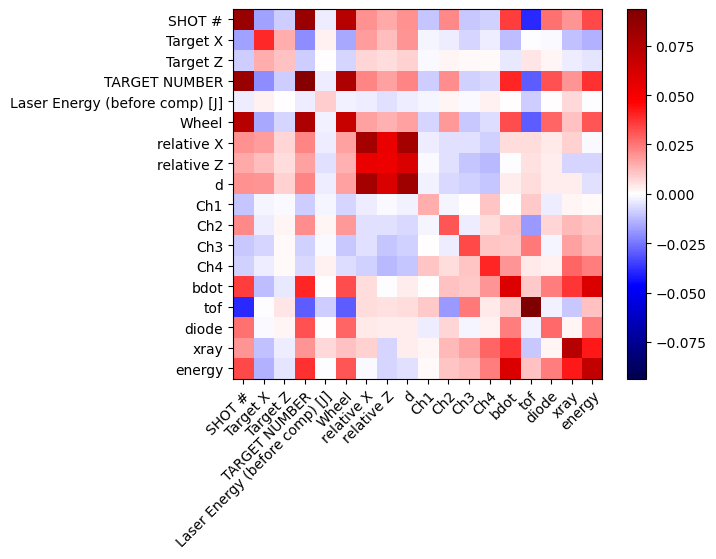

In [168]:
########### MINECRAFT BLOCK OF COVARIANCE ##############

fig, ax = plt.subplots()

pc = ax.imshow(covariance_array, norm= mplcolors.CenteredNorm(), cmap= "seismic")
fig.colorbar(pc, ax=ax)

ax.set_xticks(np.arange(len(columns)), labels=columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") #rotate x labels
ax.set_yticks(np.arange(len(rows)), labels=rows)

plt.show()

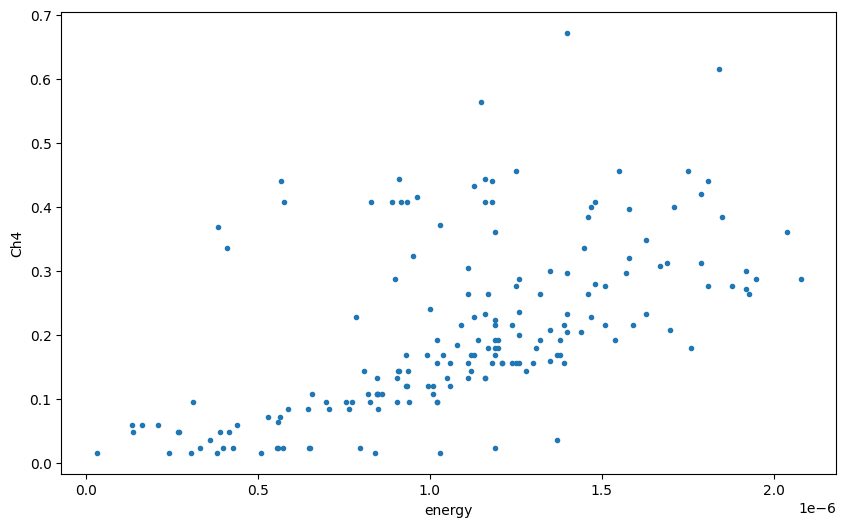

In [179]:
fig, axs = plt.subplots(1, 1, figsize= (10,6))

x = "energy"
y = "Ch4"

axs.plot(shotsheet[x], shotsheet[y], linestyle= "None", marker= ".")
axs.set(xlabel= x, ylabel= y)

plt.show()